In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
#del train,test
#train=pd.read_csv("../input/train.csv")
#test=pd.read_csv("../input/test.csv")

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


def kodeer(dfdir):
    
    mtrain=pd.read_csv(dfdir).reset_index()
    if 'experiment' in mtrain.columns:
        print('train experiment /n',mtrain.groupby('experiment').count())
    else:
        print('event',mtrain.groupby('event').count())
    
                
    features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]

    mtrain['pilot'] = 100 * mtrain['seat'] + mtrain['crew']
    print("Number of pilots : ", len(mtrain['pilot'].unique()))
    
    pilots=mtrain['pilot'].unique()
    for pilot in pilots:
        ids = mtrain[mtrain["pilot"] == pilot].index
        scaler = MinMaxScaler()
        mtrain.loc[ids, features_n] = scaler.fit_transform(mtrain.loc[ids, features_n])    
    
    mtrain=mtrain.drop('experiment',axis=1)
    
    if 'event' in mtrain.columns:
        lbl = LabelEncoder()
        mtrain['event']=lbl.fit_transform(list(mtrain['event'].values))
        lblevent=lbl
        print( list(lblevent.classes_) )
    else:
        lblevent=[]

    mtrain['groep']=np.round( mtrain.index.values/256,0 )  # 256 measurements per second = grouping per second !
    trainSD=mtrain.groupby(['groep','crew']).std()  #,'seat'
    trainMA=mtrain.groupby(['groep','crew']).mean() #,'seat'
    trainSD=trainSD.reset_index().sort_values(['crew','index']) #,'seat'
    trainMA=trainMA.reset_index().sort_values(['crew','index']) #,'seat'

    return trainSD,trainMA,lblevent,mtrain[['groep','crew']] #,'seat'

testsd,testma,lbl_event,test=kodeer("../input/test.csv")
trainsd,trainma,lbl_event,train=kodeer("../input/train.csv")


print(trainsd.shape,testsd.shape,test.shape)

train experiment /n                index        id      crew    ...          ecg         r       gsr
experiment                                  ...                                 
LOFT        17965143  17965143  17965143    ...     17965143  17965143  17965143

[1 rows x 28 columns]
Number of pilots :  18
train experiment /n               index     crew     time   ...           r      gsr    event
experiment                              ...                              
CA          1658376  1658376  1658376   ...     1658376  1658376  1658376
DA          1658393  1658393  1658393   ...     1658393  1658393  1658393
SS          1550652  1550652  1550652   ...     1550652  1550652  1550652

[3 rows x 28 columns]
Number of pilots :  18
['A', 'B', 'C', 'D']
(19022, 30) (70185, 30) (17965143, 2)


In [6]:
def SVD_tree_predict(e_,mtrain,mtest,veld,idvld):
    velden=[v for v in e_.columns if v not in [veld,idvld]]
    label = mtrain[veld].astype('int')
    mtrain[veld]=label
    print(e_.shape,velden)
    e_=e_.loc[:,velden]

    print(e_.shape)
    ncomp=e_.shape[1]-3
    # SVD
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=ncomp, n_iter=7, random_state=42)
    e_=svd.fit_transform(e_.fillna(0))
    print(e_[:len(mtrain)].shape,mtrain[veld].values.shape)
    
    xtrain=pd.DataFrame(e_[:len(mtrain)])
    xtrain[veld]=label
    xtest=pd.DataFrame(e_[len(mtrain):])
    #New_features=e_[:len(mtrain)]
    #Test_features=e_[len(mtrain):]
    pd.DataFrame(e_[:len(mtrain)]).plot.scatter(x=0,y=1,c=label,colormap='winter')
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier,ExtraTreesClassifier,GradientBoostingRegressor, AdaBoostClassifier
    from sklearn.multiclass import OneVsRestClassifier
    clf=OneVsRestClassifier(ExtraTreesClassifier(n_estimators=10))
    
    fit=clf.fit(e_[:len(mtrain)],label)
    pred=fit.predict(e_[:len(mtrain)])
    from sklearn.metrics import accuracy_score
    print('accuracy',accuracy_score(mtrain[veld].astype('int'),pred)*100)
    #predict
    sub = pd.DataFrame(fit.predict_proba(e_[len(mtrain):]))
    for ci in mtest.columns:
        sub[ci]=mtest[ci]
    
    sub.to_csv('submission.csv', index=False)
    # prepare second method
    import lightgbm as lgb
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, log_loss

    train_df, val_df = train_test_split(mtrain, test_size=0.2, random_state=420)
    print(f"Training on {train_df.shape[0]} samples.")    
    features_n = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2", "ecg", "r", "gsr"]
    features = ["crew", "seat"] + features_n
    features =[x for x in mtrain.columns if x !=veld]  
    def run_lgb(df_train, df_test):
    
        params = {"objective" : "multiclass",
                  "num_class": 4,
                  "metric" : "multi_error",
                  "num_leaves" : 30,
                  "min_child_weight" : 50,
                  "learning_rate" : 0.1,
                  "bagging_fraction" : 0.7,
                  "feature_fraction" : 0.7,
                  "bagging_seed" : 420,
                  "verbosity" : -1
                 }
    
        lg_train = lgb.Dataset(df_train[features], label=(df_train[veld]))
        lg_test = lgb.Dataset(df_test[features], label=(df_test[veld]))
        model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=50, verbose_eval=100)
    
        return model
    
    model = run_lgb(train_df, val_df)
    pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)
    print( confusion_matrix(np.argmax(pred_val, axis=1), val_df[veld].values) )
    pred_test = model.predict(mtest[features], num_iteration=model.best_iteration) #mtest[features]
    submission = pd.DataFrame(np.concatenate((np.arange(len(mtest))[:, np.newaxis], pred_test), axis=1), columns=['id', 'A', 'B', 'C', 'D'])
    submission['id'] = submission['id'].astype(int)
    
    return sub,submission

In [7]:
trainMS=trainma.merge(trainsd,left_index=True,right_index=True)
testMS=testma.merge(testsd,left_index=True,right_index=True)
trainma['event']=trainma['event']+0.249 #*2
trainma['event']=trainma['event'].map(round)

trainma.groupby('event').count(),trainma.shape,testma.shape,trainMS.shape,testMS.shape

(       groep   crew  index   time  ...      ecg      r    gsr  pilot
 event                              ...                              
 0      10831  10831  10831  10831  ...    10831  10831  10831  10831
 1        707    707    707    707  ...      707    707    707    707
 2       6758   6758   6758   6758  ...     6758   6758   6758   6758
 3        726    726    726    726  ...      726    726    726    726
 
 [4 rows x 29 columns], (19022, 30), (70185, 30), (19022, 60), (70185, 60))

In [8]:
trainMS

,groep_x,crew_x,index_x,time_x,seat_x,eeg_fp1_x,eeg_f7_x,eeg_f8_x,eeg_t4_x,eeg_t6_x,eeg_t5_x,eeg_t3_x,eeg_fp2_x,eeg_o1_x,eeg_p3_x,eeg_pz_x,eeg_f3_x,eeg_fz_x,eeg_f4_x,eeg_c4_x,eeg_p4_x,eeg_poz_x,eeg_c3_x,eeg_cz_x,eeg_o2_x,ecg_x,r_x,gsr_x,event_x,pilot_x,groep_y,crew_y,index_y,time_y,seat_y,eeg_fp1_y,eeg_f7_y,eeg_f8_y,eeg_t4_y,eeg_t6_y,eeg_t5_y,eeg_t3_y,eeg_fp2_y,eeg_o1_y,eeg_p3_y,eeg_pz_y,eeg_f3_y,eeg_fz_y,eeg_f4_y,eeg_c4_y,eeg_p4_y,eeg_poz_y,eeg_c3_y,eeg_cz_y,eeg_o2_y,ecg_y,r_y,gsr_y,event_y,pilot_y
0,0.0,1,64.0,0.207031,0.666667,0.484201,0.565879,0.556133,0.570752,0.536640,0.634152,0.564752,0.508289,0.520594,0.529823,0.526762,0.525155,0.481349,0.562434,0.542250,0.552078,0.524187,0.510756,0.491609,0.377429,0.291160,0.547566,0.442048,0.000000,67.666667,0.0,1,37.383151,0.094007,0.473242,0.125954,0.017264,0.051943,0.052715,0.067107,0.049070,0.046812,0.115570,0.075076,0.066369,0.019975,0.074004,0.093287,0.066739,0.055801,0.045932,0.079774,0.093376,0.031890,0.069870,0.194632,0.051436,0.164246,0.000000,47.324236
1,1.0,1,256.0,0.596676,0.501961,0.461935,0.567405,0.558469,0.564552,0.517301,0.658230,0.549253,0.490370,0.505740,0.508416,0.526506,0.513360,0.463609,0.556141,0.528911,0.535956,0.510271,0.487683,0.510941,0.410541,0.223089,0.558010,0.496562,0.000000,51.196078,1.0,1,73.756356,0.144059,0.500979,0.159790,0.033880,0.070070,0.066077,0.082439,0.049127,0.064637,0.153168,0.085591,0.083339,0.044603,0.091834,0.115100,0.085936,0.074992,0.066473,0.091291,0.107363,0.041834,0.085933,0.209102,0.078240,0.177199,0.000000,50.097943
2,2.0,1,512.0,1.096683,0.498054,0.449987,0.564955,0.546156,0.557256,0.515542,0.662143,0.544957,0.471115,0.515034,0.504356,0.505225,0.508784,0.457106,0.545846,0.522615,0.533608,0.516600,0.485264,0.484717,0.424525,0.227603,0.556041,0.495606,0.000000,50.805447,2.0,1,74.333707,0.145186,0.500972,0.129017,0.025814,0.057427,0.064023,0.084043,0.047309,0.068450,0.123907,0.076482,0.086311,0.039871,0.081620,0.102879,0.075576,0.073054,0.065147,0.084711,0.102085,0.035807,0.093026,0.208023,0.091798,0.180364,0.000000,50.097182
3,3.0,1,768.0,1.596676,0.501961,0.437567,0.560820,0.538316,0.545807,0.505329,0.656441,0.547841,0.457693,0.515410,0.509041,0.495933,0.495506,0.420438,0.535020,0.516750,0.526662,0.514738,0.482573,0.438707,0.412495,0.239124,0.562792,0.494034,0.000000,51.196078,3.0,1,73.756356,0.144059,0.500979,0.131591,0.013317,0.050210,0.058855,0.072515,0.067886,0.045286,0.128921,0.056276,0.063137,0.046052,0.075556,0.080198,0.073201,0.064215,0.054640,0.066851,0.087879,0.063981,0.091373,0.219832,0.066224,0.181646,0.000000,50.097943
4,4.0,1,1024.0,7.668668,0.498054,0.451619,0.563366,0.547151,0.562789,0.515415,0.649851,0.544972,0.475961,0.502130,0.508251,0.527633,0.505267,0.454320,0.551924,0.531220,0.542008,0.522447,0.481540,0.471530,0.424055,0.231500,0.574886,0.519853,1.392996,50.805447,4.0,1,74.333707,3.801971,0.500972,0.119658,0.012975,0.047701,0.042966,0.062866,0.061723,0.049548,0.112357,0.067087,0.065052,0.038153,0.067579,0.076830,0.058212,0.051984,0.040094,0.061588,0.089542,0.045088,0.101018,0.218598,0.060414,0.171165,0.921334,50.097182
5,5.0,1,1280.0,10.596676,0.501961,0.455240,0.563316,0.542925,0.551908,0.501866,0.647555,0.537653,0.480490,0.488672,0.495588,0.497585,0.503155,0.451736,0.541264,0.517704,0.523541,0.497276,0.477656,0.486157,0.401353,0.244334,0.586195,0.530261,2.000000,51.196078,5.0,1,73.756356,0.144059,0.500979,0.116661,0.012567,0.053097,0.055264,0.075445,0.059679,0.054960,0.110542,0.079802,0.074393,0.036485,0.070311,0.075404,0.070093,0.066573,0.055410,0.079521,0.094572,0.039269,0.081829,0.224402,0.046317,0.165073,0.000000,50.097943
6,6.0,1,1536.0,73.085010,0.501946,0.440937,0.555951,0.535552,0.553280,0.505352,0.647854,0.527200,0.462264,0.512558,0.504104,0.542239,0.500740,0.455652,0.534421,0.519057,0.534614,0.517370,0.480377,0.486690,0.419110,0.221345,0.585944,0.571625,2.000000,51.194553,6.0,1,74.333707,41.115092,0.500972,0.124792,0.015935,0.050122,0.048550,0.066568,0.064399,0.067025,0.119379,0.065188,0.061302,

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(89207, 46) ['ecg_x', 'ecg_y', 'eeg_c3_x', 'eeg_c3_y', 'eeg_c4_x', 'eeg_c4_y', 'eeg_cz_x', 'eeg_cz_y', 'eeg_f3_x', 'eeg_f3_y', 'eeg_f4_x', 'eeg_f4_y', 'eeg_f7_x', 'eeg_f7_y', 'eeg_f8_x', 'eeg_f8_y', 'eeg_fp1_x', 'eeg_fp1_y', 'eeg_fp2_x', 'eeg_fp2_y', 'eeg_fz_x', 'eeg_fz_y', 'eeg_o1_x', 'eeg_o1_y', 'eeg_o2_x', 'eeg_o2_y', 'eeg_p3_x', 'eeg_p3_y', 'eeg_p4_x', 'eeg_p4_y', 'eeg_poz_x', 'eeg_poz_y', 'eeg_pz_x', 'eeg_pz_y', 'eeg_t3_x', 'eeg_t3_y', 'eeg_t4_x', 'eeg_t4_y', 'eeg_t5_x', 'eeg_t5_y', 'eeg_t6_x', 'eeg_t6_y', 'gsr_x', 'gsr_y', 'r_x', 'r_y']
(89207, 46)
(19022, 43) (19022,)
accuracy 100.0
Training on 15217 samples.
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0785808
[200]	valid_0's multi_error: 0.0756899
Early stopping, best iteration is:
[217]	valid_0's multi_error: 0.074113
[[2195  136   31   92]
 [   4   22    1    1]
 [   9    3 1280    0]
 [   3    1    1   26]]


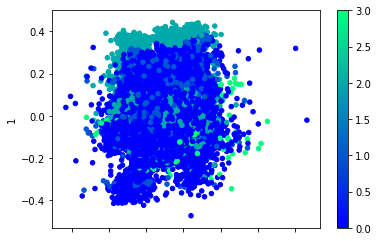

In [9]:
#subx=SVD_tree_predict(trainMS.append(testMS).drop(['index_x','index_y','id_x','id_y','pilot_x','pilot_y','time_x','time_y','event_y','groep_y','event_x','crew_x','crew_y','seat_x','seat_y'],axis=1), trainma,testma,'event','groep')
dropveld=['index_x','index_y','id_x','id_y','pilot_x','pilot_y','time_x','time_y','event_y','groep_x','groep_y','event_x','crew_x','crew_y','seat_x','seat_y']
dropveld1=['index_x','index_y','pilot_x','pilot_y','time_x','time_y','groep_x','groep_y','crew_x','crew_y','seat_x','seat_y','event_y']

dropveld2=['index_x','index_y','pilot_x','pilot_y','time_x','time_y','groep_x','groep_y','crew_x','crew_y','seat_x','seat_y']

#subx,subg=SVD_tree_predict(trainma.append(testma).drop(['index','id','pilot','time','groep','event','crew','seat'],axis=1), trainma,testma,'event','groep')
subx,subg=SVD_tree_predict(trainMS.append(testMS).drop(dropveld,axis=1), trainMS.drop(dropveld1,axis=1),testMS.drop(dropveld2,axis=1),'event_x','groep')

In [11]:
subx #[['groep','crew','seat']]
subg

,id,A,B,C,D
0,0,0.973249,0.008629,0.004322,0.013800
1,1,0.986898,0.003763,0.003664,0.005675
2,2,0.978928,0.008791,0.003553,0.008729
3,3,0.982639,0.003772,0.001588,0.012002
4,4,0.956181,0.024604,0.006909,0.012305
5,5,0.813448,0.116395,0.064011,0.006146
6,6,0.919831,0.048604,0.021321,0.010244
7,7,0.832632,0.091353,0.050519,0.025496
8,8,0.834291,0.028107,0.118433,0.019169
9,9,0.976418,0.006189,0.002031,0.015363


In [12]:
sub2=subx.iloc[:,:7]
sub2.columns=['A','B','C','D','groep','crew','seat']
sub2.head()

,A,B,C,D,groep,crew,seat
0,0.727273,0.000000,0.181818,0.090909,64.0,0.383012,0.514356
1,0.800000,0.200000,0.000000,0.000000,256.0,0.402466,0.528750
2,0.777778,0.000000,0.111111,0.111111,512.0,0.380530,0.507213
3,0.714286,0.000000,0.214286,0.071429,768.0,0.376678,0.501151
4,0.636364,0.181818,0.090909,0.090909,1024.0,0.397924,0.582578


In [13]:
#sub2=subx.groupby('groep').median()
#sub2=subx[:int(len(subx)/2)]
test

,groep,crew
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1
5,0.0,1
6,0.0,1
7,0.0,1
8,0.0,1
9,0.0,1


In [15]:
#testSD=testSD.merge(subx,left_on='groep',right_on='groep')
#testSD['event']=lblevent.inverse_transform(testSD['event_x'])


#test=pd.read_csv("../input/test.csv")
#test['groep']=np.round( test.index.values/200,0 )
#test2=test.merge(sub2,how='left',left_on=['groep','crew'],right_on=['groep','crew']) #','seat'
test2=test.merge(subg,how='left',left_on=['groep'],right_on=['id']) #','seat'
#test2.groupby('event_x').count()
#test2=test2.drop(['groep','crew','seat'],axis=1)  #,'seat'
test2=test2.drop(['groep','id','crew'],axis=1)  #,'seat'
test2.index.names = ['id']
test2=test2.reset_index()

test2

,id,A,B,C,D
0,0,0.973249,0.008629,0.004322,0.013800
1,1,0.973249,0.008629,0.004322,0.013800
2,2,0.973249,0.008629,0.004322,0.013800
3,3,0.973249,0.008629,0.004322,0.013800
4,4,0.973249,0.008629,0.004322,0.013800
5,5,0.973249,0.008629,0.004322,0.013800
6,6,0.973249,0.008629,0.004322,0.013800
7,7,0.973249,0.008629,0.004322,0.013800
8,8,0.973249,0.008629,0.004322,0.013800
9,9,0.973249,0.008629,0.004322,0.013800


In [16]:
test2.to_csv('submission.csv', index=False)